<a href="https://colab.research.google.com/github/Tharunyasri-10/Toxic-Comment-Classifier/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# 1. Import Libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gradio as gr

In [2]:
!pip install gradio


In [ ]:
df = pd.read_csv('train.csv')  # Make sure the path is correct
df = df[['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]  # Select required columns

# 3. Preprocessing
X = df['comment_text'].values
y = df[df.columns[1:]].values

In [ ]:
MAX_FEATURES = 200000
SEQUENCE_LENGTH = 1800

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=SEQUENCE_LENGTH,
                               output_mode='int')
vectorizer.adapt(X)

# Vectorize the data
X_vectorized = vectorizer(X)

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((X_vectorized, y))
dataset = dataset.shuffle(buffer_size=10000).batch(16).prefetch(tf.data.AUTOTUNE)

# Split the dataset
total_batches = len(dataset)
train_size = int(0.7 * total_batches)
val_size = int(0.2 * total_batches)

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size)


In [ ]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.5.2
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.7.0.35.30
astunparse                            1.

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, input_length=1800))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# 👇 Compile before training
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Optional: build model or run dummy input before summary
model.build(input_shape=(None, 1800))
model.summary()

# 👇 Now you can train
history = model.fit(train, epochs=1, validation_data=val)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 660s 93ms/step - accuracy: 0.9436 - loss: 0.0882 - val_accuracy: 0.9941 - val_loss: 0.0496


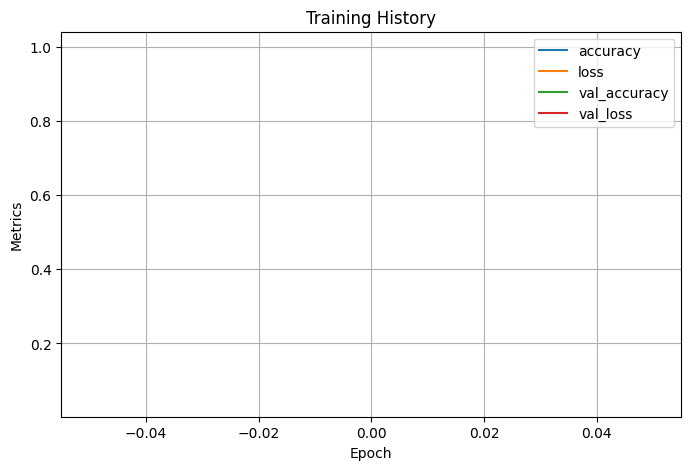

In [ ]:
# 6. Visualize Training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.grid(True)
plt.show()

In [ ]:
model.save('toxicity_model.h5')
model = tf.keras.models.load_model('toxicity_model.h5')

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)[0]

    labels = df.columns[1:]
    output = "\n".join(f"{label}: {'✅' if score > 0.5 else '❌'} ({score:.2f})" for label, score in zip(labels, results))
    return output

interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=4, placeholder="Enter a comment..."),
    outputs="text",
    title="Toxic Comment Classifier",
    description="Enter a comment to see which categories it might fall under (e.g., toxic, insult, threat, etc.)"
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://07323b3e629c49cc43.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
